## Imports


In [1]:
import warnings

warnings.filterwarnings("ignore")

from rich import print
from datasets import load_dataset

## Dataset


In [2]:
dataset = load_dataset("PodYapolsky/LogoDet-3K")

company2id = {
    name: idx
    for idx, name in enumerate(dataset["train"].features["company_name"].names)
}
id2company = {v: k for k, v in company2id.items()}

Generating test split: 100%|██████████| 31731/31731 [00:01<00:00, 20243.77 examples/s]


In [3]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_path', 'industry_name', 'company_name', 'bbox'],
        num_rows: 126923
    })
    test: Dataset({
        features: ['image_path', 'industry_name', 'company_name', 'bbox'],
        num_rows: 31731
    })
})

In [4]:
company2id["play-doh"], id2company[2186]

(2186, 'play-doh')

## Visualization


In [5]:
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
import io


plt.rcParams["figure.figsize"] = (16, 10)  # (w, h)


def show_imgs(
    rows: list,
    titles: list[str] = None,
    show_bb: bool = False,
    disable_ticks: bool = False,
):
    if titles:
        assert len(rows) == len(titles)

    count = len(rows)
    for idx in range(count):
        subplot = plt.subplot(count // 5 + 1, 5, idx + 1)

        # set title to specific id
        if titles is not None:
            subplot.set_title(titles[idx])

        row = rows[idx]
        img = row["image_path"]
        if isinstance(img, Image.Image):
            pass
        elif isinstance(img, dict):
            img = Image.open(io.BytesIO(img["bytes"]))
        elif isinstance(img, np.ndarray):
            img = Image.fromarray(img)
        else:
            raise TypeError("img is of inappropriate type")

        # draw bounding vox
        if show_bb:
            xmin, ymin, xmax, ymax = row["bbox"]
            draw = ImageDraw.Draw(img)
            draw.rectangle([(xmin, ymin), (xmax, ymax)], outline="green", width=3)

        # cmap = "gray" if (len(img.shape) == 2 or img.shape[2] == 1) else None
        subplot.imshow(np.asarray(img, dtype=np.float32) / 255, cmap=None)

        if disable_ticks:
            plt.xticks([]), plt.yticks([])

    plt.show()

{
    'image_path': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=387x520 at 0x74F6DE14F920>,
    'industry_name': 'Clothes',
    'company_name': 2020,
    'bbox': [22, 68, 366, 448]
}

nicole lee-1

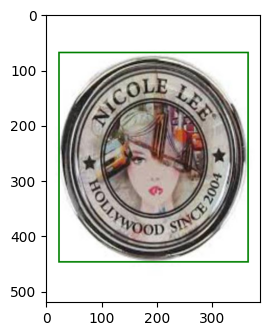

In [6]:
row = dataset["train"][0]
print(row)
print(id2company[row["company_name"]])

show_imgs([row], show_bb=True)

## Play Doh Example

Обозначим компанию Play Doh - искомой


In [7]:
play_dohs = dataset.filter(lambda row: row["company_name"] == company2id["play-doh"])

Filter: 100%|██████████| 31731/31731 [00:21<00:00, 1446.44 examples/s]


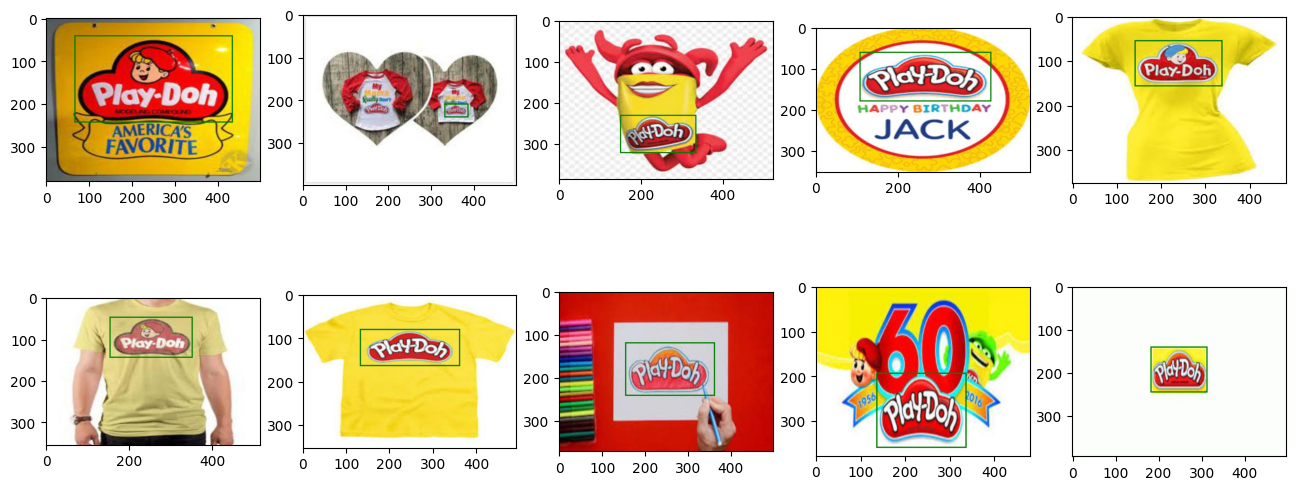

In [8]:
play_dohs_train_10 = play_dohs["train"].to_list()[:10]
show_imgs(play_dohs_train_10, show_bb=True)

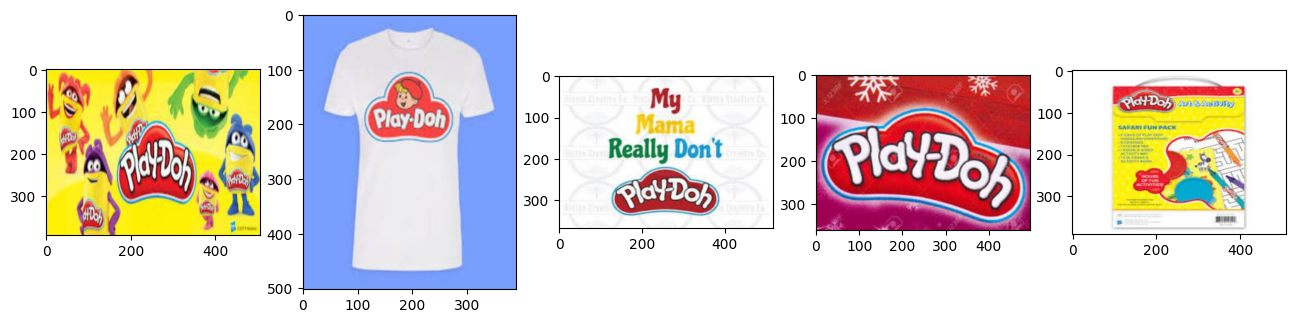

In [9]:
play_dohs_test_5 = play_dohs["test"].to_list()[:5]
show_imgs(play_dohs_test_5, show_bb=False)

{
    'image_path': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=517x368 at 0x74F679586750>,
    'industry_name': 'Leisure',
    'company_name': 2186,
    'bbox': [111, 216, 398, 345]
}

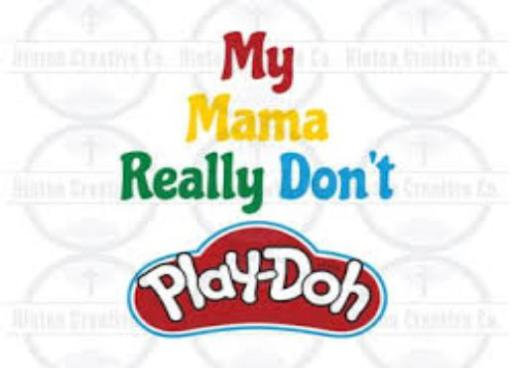

In [10]:
test_row = play_dohs["test"][2]
print(test_row)

test_row["image_path"]

## SIFT

Let's try on simple play doh example


In [11]:
from PIL import Image


def crop_to_bb(row: dict) -> Image.Image:
    img: Image.Image = row["image_path"]
    img = img.crop(row["bbox"])
    return img

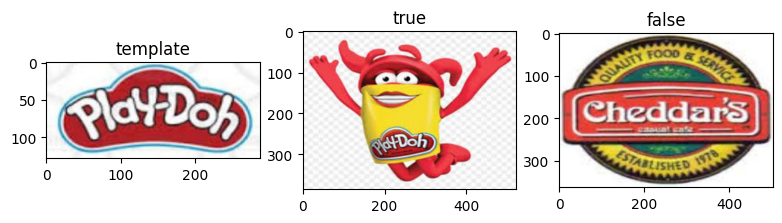

In [12]:
import numpy as np

template: np.ndarray = np.array(crop_to_bb(play_dohs["test"][2]))
image: np.ndarray = np.array(play_dohs["train"][2]["image_path"])
image2: np.ndarray = np.array(dataset["train"][21]["image_path"])

rows = [{"image_path": image} for image in [template, image, image2]]
show_imgs(rows, ["template", "true", "false"])

In [20]:
import cv2


def detect(
    image: np.ndarray, template: np.ndarray
) -> tuple[bool, np.ndarray, np.ndarray]:
    """Функция, которая пытается найти template на image.

    Args:
        image (np.ndarray): основная картинка
        template (np.ndarray): паттерн, который ходим найти

    Returns:
        tuple[bool, np.ndarray, nd.ndarray]: есть ли паттерн, задетектированный паттерн на картинке (если найден), мэтчинг линий (если найден)
    """
    # сохраним цветные версии
    image_color = image.copy()
    template_color = template.copy()

    # конвертируем цвета в серый, чтобы быть инвариантым к цвету паттерна
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    template = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # используем бэйзлайн детектор
    detector = cv2.SIFT.create()

    # находим keypoints и descriptors на обеих картинках
    kp_image, des_image = detector.detectAndCompute(image, None)
    kp_template, des_template = detector.detectAndCompute(template, None)

    # исползуем BFMatcher чтобы найти matches между descriptors
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(des_template, des_image, k=2)

    # FLANN stands for Fast Library for Approximate Nearest Neighbors
    # https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html
    # FLANN_INDEX_KDTREE = 1
    # flann = cv2.FlannBasedMatcher(
    #     indexParams=dict(algorithm=FLANN_INDEX_KDTREE, trees=5),
    #     searchParams=dict(checks=50),
    # )
    # matches = flann.knnMatch(des1, des2, k=2)

    # сравниваем через отношение (гиперпараметр) дистанции и добавлеем хорошие совпадения
    good_matches = []
    ratio_thresh = 0.75
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    # минимальное количество хороших совпадений, чтобы утверждать, что паттер присутствует (также гиперпараметр)
    MIN_MATCH_COUNT = 20
    if len(good_matches) >= MIN_MATCH_COUNT:
        # извлекаем места, где точки совпали на обеих картинках
        src_pts = np.float32(
            [kp_template[m.queryIdx].pt for m in good_matches]
        ).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_image[m.trainIdx].pt for m in good_matches]).reshape(
            -1, 1, 2
        )

        # считаем есть ли такая матрица, позволяющая перенести точки одной картинки в другую
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        if M is not None:
            # получаем размеры паттерна (каналов нет, потому что картинки обезсвечены)
            h, w = template.shape

            # получаем углы паттерна и переводим их в координаты image
            pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(
                -1, 1, 2
            )
            dst = cv2.perspectiveTransform(pts, M)

            # рисуем полигон около обнарженного паттерна на главной картинке
            img_detected = cv2.polylines(
                image_color, [np.int32(dst)], True, (0, 255, 0), 3, shift=0
            )

            # также можем визуализировать процесс матчинга
            draw_params = dict(
                matchColor=(0, 255, 0),  # рисуем синими линиями сматченные точки
                singlePointColor=None,
                matchesMask=mask.ravel().tolist(),  # рисуем только корректные точки (inliers)
                flags=2,
            )
            img_matches = cv2.drawMatches(
                template_color,
                kp_template,
                image_color,
                kp_image,
                good_matches,
                None,
                **draw_params,
            )

            return True, img_detected, img_matches

    return False, image_color, np.ones(shape=(0))

In [27]:
is_detected, detected, matches = detect(image=image, template=template)

True

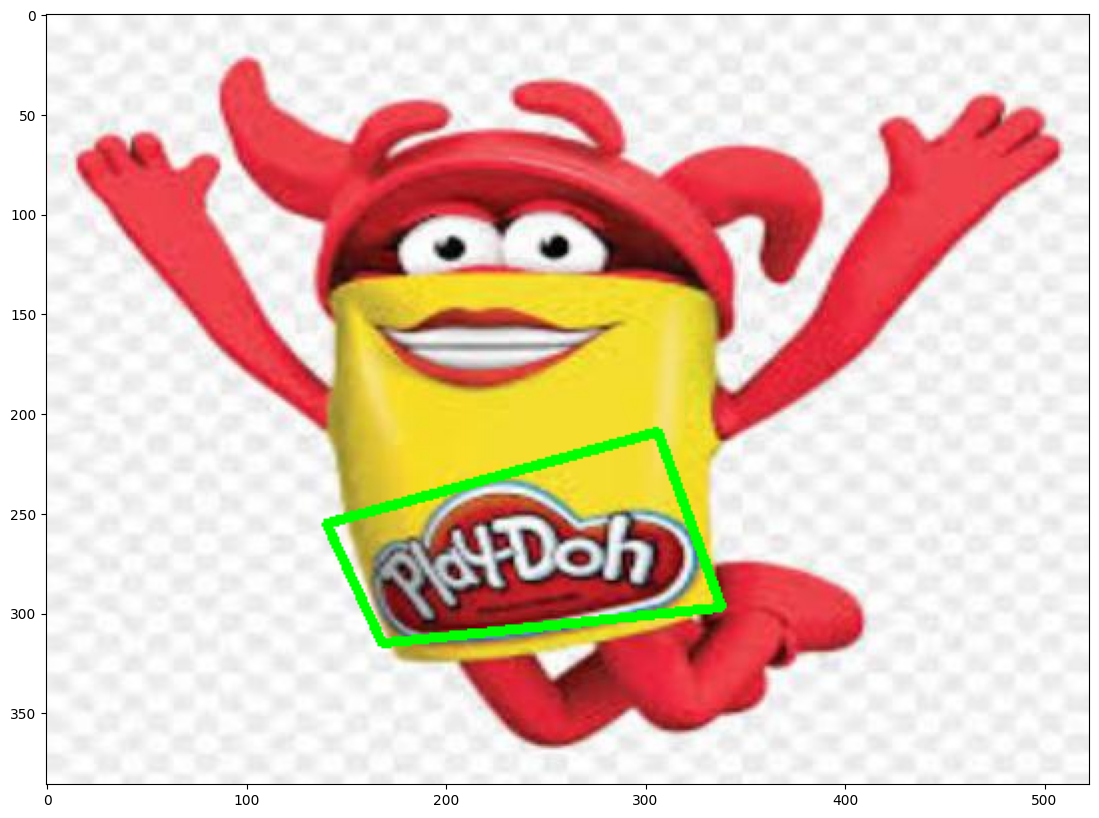

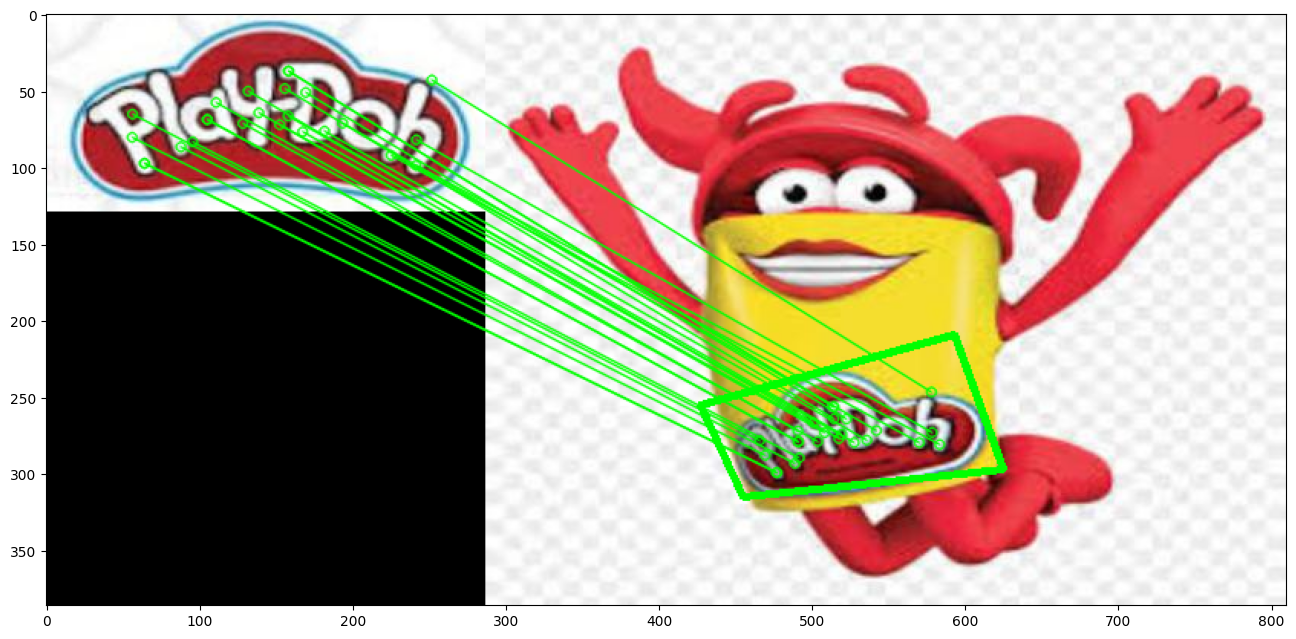

In [31]:
print(is_detected)

if is_detected:
    plt.imshow(detected)
    plt.show()
    plt.imshow(matches)
    plt.show()

In [33]:
is_detected, detected, matches = detect(image=image2, template=template)

In [34]:
print(is_detected)

if is_detected:
    plt.imshow(detected)
    plt.show()
    plt.imshow(matches)
    plt.show()

False

## YOLO


In [ ]:
import torch

# Model
model = torch.hub.load("ultralytics/yolov5", "yolov5s")  # or yolov5n - yolov5x6, custom

# Images
img = test_row["image_path"]  # or file, Path, PIL, OpenCV, numpy, list

# Inference
results = model(img)

# Results
results.print()  # or .show(), .save(), .crop(), .pandas(), etc.

In [ ]:
results.show()

TRY TRAINING YOLO
